# rf603_multicpu
Likelihood and minimization: setting up a multi-core parallelized unbinned maximum likelihood fit




**Author:**  Clemens Lange, Wouter Verkerke (C++ version)  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Wednesday, April 17, 2024 at 11:19 AM.</small></i>

In [1]:
import ROOT

Create 3D pdf and data
-------------------------------------------

Create observables

In [2]:
x = ROOT.RooRealVar("x", "x", -5, 5)
y = ROOT.RooRealVar("y", "y", -5, 5)
z = ROOT.RooRealVar("z", "z", -5, 5)

Create signal pdf gauss(x)*gauss(y)*gauss(z)

In [3]:
gx = ROOT.RooGaussian("gx", "gx", x, 0.0, 1.0)
gy = ROOT.RooGaussian("gy", "gy", y, 0.0, 1.0)
gz = ROOT.RooGaussian("gz", "gz", z, 0.0, 1.0)
sig = ROOT.RooProdPdf("sig", "sig", [gx, gy, gz])

Create background pdf poly(x)*poly(y)*poly(z)

In [4]:
px = ROOT.RooPolynomial("px", "px", x, [-0.1, 0.004])
py = ROOT.RooPolynomial("py", "py", y, [0.1, -0.004])
pz = ROOT.RooPolynomial("pz", "pz", z)
bkg = ROOT.RooProdPdf("bkg", "bkg", [px, py, pz])

Create composite pdf sig+bkg

In [5]:
fsig = ROOT.RooRealVar("fsig", "signal fraction", 0.1, 0.0, 1.0)
model = ROOT.RooAddPdf("model", "model", [sig, bkg], [fsig])

Generate large dataset

In [6]:
data = model.generate({x, y, z}, 200000)

Parallel fitting
-------------------------------

In parallel mode the likelihood calculation is split in N pieces,
that are calculated in parallel and added a posteriori before passing
it back to MINUIT.

Use four processes and time results both in wall time and CPU time

In [7]:
model.fitTo(data, NumCPU=4, Timer=True, PrintLevel=-1)

<cppyy.gbl.RooFitResult object at 0x(nil)>

[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation library compiled with -mavx2
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_modelData) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- Command timer: Real time 0:00:00, CP time 0.180
[#1] INFO:Minimization -- Session timer: Real time 0:00:00, CP time 0.180
[#1] INFO:Minimization -- Command timer: Real time 0:00:00, CP time 0.020
[#1] INFO:Minimization -- Session timer: Real time 0:00:00, CP time 0.200, 2 slices
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


Parallel MC projections
----------------------------------------------

Construct signal, likelihood projection on (y,z) observables and
likelihood ratio

In [8]:
sigyz = sig.createProjection({x})
totyz = model.createProjection({x})
llratio_func = ROOT.RooFormulaVar("llratio", "log10(@0)-log10(@1)", [sigyz, totyz])

Calculate likelihood ratio for each event, subset of events with high
signal likelihood

In [9]:
data.addColumn(llratio_func)
dataSel = data.reduce(Cut="llratio>0.7")

[#1] INFO:InputArguments -- The formula llratio>0.7 claims to use the variables (x,z,y,llratio) but only (llratio) seem to be in use.
  inputs:         llratio>0.7


Make plot frame and plot data

In [10]:
frame = x.frame(Title="Projection on X with LLratio(y,z)>0.7", Bins=40)
dataSel.plotOn(frame)

Perform parallel projection using MC integration of pdf using given input dataSet.
In self mode the data-weighted average of the pdf is calculated by splitting the
input dataset in N equal pieces and calculating in parallel the weighted average
one each subset. The N results of those calculations are then weighted into the
final result

Use four processes

In [11]:
model.plotOn(frame, ProjWData=dataSel, NumCPU=4)

c = ROOT.TCanvas("rf603_multicpu", "rf603_multicpu", 600, 600)
ROOT.gPad.SetLeftMargin(0.15)
frame.GetYaxis().SetTitleOffset(1.6)
frame.Draw()

c.SaveAs("rf603_multicpu.png")

[#1] INFO:Plotting -- RooAbsReal::plotOn(model) plot on x averages using data variables (z,y)
[#1] INFO:Plotting -- RooAbsReal::plotOn(model) only the following components of the projection data will be used: (z,y)


Info in <TCanvas::Print>: png file rf603_multicpu.png has been created


Draw all canvases 

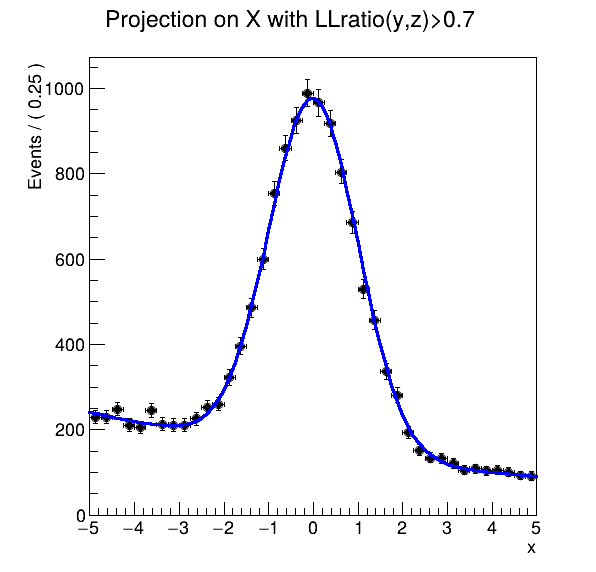

In [12]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()